In [1]:
import os
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.width', 240)

In [2]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (16.0, 9.0)
matplotlib.rcParams['figure.max_open_warning'] = 100

In [3]:
# Progress bar helper to indicate that slow tasks have not stalled
from tqdm.auto import tqdm

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [5]:
PICKS_PATH = r"C:\data_cache\Picks\20190219\ensemble.p.txt"
#PICKS_PATH = r"C:\data_cache\Picks\20190219\ensemble_small.p.txt"
dtype = {'#eventID': object,
    'originTimestamp': np.float64,
    'mag':                    np.float64,
    'originLon':              np.float64,
    'originLat':              np.float64,
    'originDepthKm':          np.float64,
    'net':                     object,
    'sta':                     object,
    'cha':                     object,
    'pickTimestamp':          np.float64,
    'phase':                   object,
    'stationLon':             np.float64,
    'stationLat':             np.float64,
    'az':                     np.float64,
    'baz':                    np.float64,
    'distance':               np.float64,
    'ttResidual':             np.float64,
    'snr':                    np.float64,
    'qualityMeasureCWT':      np.float64,
    'domFreq':                np.float64,
    'qualityMeasureSlope':    np.float64,
    'bandIndex':              np.int64,
    'nSigma':                 np.int64}

In [6]:
df_raw_picks = pd.read_csv(PICKS_PATH, ' ', header=0, dtype=dtype)
len(df_raw_picks)

5602653

In [66]:
# Pull up waveforms for outlier event
import obspy

print(obspy.UTCDateTime(df_raw_picks['originTimestamp'].min()))
print(obspy.UTCDateTime(df_raw_picks['originTimestamp'].max()))

1993-01-02T04:05:03.344000Z
2018-05-22T05:58:46.550000Z


In [7]:
# Priority order of trusted channels
# channel_pref = ['BHZ_00', 'BHZ', 'BHZ_10', 'B?Z', 'S?Z', 'SHZ', '???', '?']
channel_pref = ['BHZ_00', 'BHZ', 'BHZ_10', 'B?Z']

In [8]:
# Remove non-BHZ channels as their picks are not considered reliable enough to use
df_picks = df_raw_picks[df_raw_picks['cha'].isin(channel_pref)].reset_index()
len(df_picks)

3055236

In [9]:
# Remove unused columns for readability
df_picks = df_picks[['#eventID', 'originTimestamp', 'mag', 'originLon', 'originLat', 'originDepthKm', 'net', 'sta', 'cha', 'pickTimestamp', 'phase', 
                     'stationLon', 'stationLat', 'az', 'baz', 'distance', 'ttResidual', 'snr', 'qualityMeasureCWT', 'qualityMeasureSlope', 'nSigma']]

In [10]:
def getNetworkStations(df, netcode):
    return sorted(df[df['net'] == netcode]['sta'].unique().tolist())

In [11]:
def getNetworkMean(df, netcode):
    mean_lat = df[df['net'] == netcode]['stationLat'].mean()
    mean_lon = df[df['net'] == netcode]['stationLon'].mean()
    return (mean_lat, mean_lon)

In [12]:
#---
# REF_NET = 'AU'
# REF_STN = 'MTN'
#---
# REF_NET = 'IR'
# REF_STN = 'WRAB'
#---
# REF_NET = 'AU'
# REF_STN = 'QIS' # Doesn't have much BHZ data
#---
# REF_NET = 'AU'
# REF_STN = 'ARMA'
#---
REF_NET = 'AU'
REF_STN = 'CMSA'
#---
# REF_NET = 'AU'
# REF_STN = 'QLP'
#---
REF = {'net': [REF_NET], 'sta': [REF_STN]}

In [35]:
#---
# TARGET_NET = 'AU'
# STN_LIST = ['KDU']
#---
# TARGET_NET = 'AU'
# STN_LIST = ['WR0', 'WR1', 'WR2', 'WR3', 'WR4', 'WR5', 'WR6', 'WR7','WR8', 'WR9', 'WR10']
#---
# TARGET_NET = '7X'
# STN_LIST = ['MA01', 'MA33', 'MA41', 'MA42', 'MA43', 'MA44', 'MA51', 'MA62', 'MIL7']
#---
TARGET_NET = '7D'
STN_LIST = getNetworkStations(df_picks, TARGET_NET)
STN_LIST = STN_LIST[0:8] # take a subset
#---
# TARGET_NET = '7G'
# STN_LIST = getNetworkStations(df_picks, TARGET_NET)
# STN_LIST = STN_LIST[0:22] # take a 1/3 subset
#---
# TARGET_NET = 'AU'
# STN_LIST = ['ARMA']
#---
TARGET_STNS = {'net': [TARGET_NET]*len(STN_LIST), 'sta': [s for s in STN_LIST]}

In [36]:
def display_styled_table(df):
    # Display table with blocks of same event ID highlighted
    df['lastEventID'] = df['#eventID'].shift(1)
    df['lastEventID'].iloc[0] = df['#eventID'].iloc[0]
    cols = ['#ffffff', '#e0e0ff']
    def block_highlighter(r):
        if r['lastEventID'] != r['#eventID']:
            block_highlighter.current_col = (block_highlighter.current_col + 1) % len(cols)
        return ['background-color: ' + cols[block_highlighter.current_col]]*len(r)
    block_highlighter.current_col = 0
    return df.style.apply(block_highlighter, axis=1)

## Remove reference station records where the SNR is too low

In [37]:
min_ref_snr = 10
mask_ref = df_picks[list(REF)].isin(REF).all(axis=1)
mask_ref_snr = ~mask_ref | (mask_ref & (df_picks['snr'] >= min_ref_snr))
df_good_ref_snr = df_picks.loc[mask_ref_snr]
len(df_good_ref_snr)

3051317

## Filter to teleseismic events

In [38]:
# Column heading for the angular distance (degrees) between event and station
ANG_DIST = 'distance'
mask_tele = (df_good_ref_snr[ANG_DIST] >= 30.0) & (df_good_ref_snr[ANG_DIST] <= 90.0)
df_tele = df_good_ref_snr.loc[mask_tele]
len(df_tele)

2324532

## Filter to constrained quality metrics

In [39]:
cwt_cutoff = 15
slope_cutoff = 3
nsigma_cutoff = 4
# cwt_cutoff = 0
# slope_cutoff = 0
# nsigma_cutoff = 0
mask_cwt = (df_tele['qualityMeasureCWT'] >= cwt_cutoff)
mask_slope = (df_tele['qualityMeasureSlope'] >= slope_cutoff)
mask_sigma = (df_tele['nSigma'] >= nsigma_cutoff)
# Make sure we DON'T filter out the reference station, which may have zero quality values
mask_ref = df_tele[list(REF)].isin(REF).all(axis=1)
quality_mask = (mask_cwt & mask_slope & mask_sigma) | mask_ref

In [40]:
assert np.sum(quality_mask) > 100, 'Not enough points left after quality filtering'
df_qual = df_tele[quality_mask]
# df_qual = df_tele
len(df_qual)

100621

In [41]:
# display_styled_table(df_qual[0:200])

## Filter to desired ref and target networks

In [42]:
mask_ref = df_qual[list(REF)].isin(REF).all(axis=1)
mask_targ = df_qual[list(TARGET_STNS)].isin(TARGET_STNS).all(axis=1)
mask = mask_ref | mask_targ
np.any(mask)

True

In [43]:
df_nets = df_qual.loc[mask]
len(df_nets)

3028

In [44]:
# Filter out events in which REF and TARGET stations are not both present
keep_events = [e for e, d in df_nets.groupby('#eventID') if np.any(d[list(REF)].isin(REF).all(axis=1)) and np.any(d[list(TARGET_STNS)].isin(TARGET_STNS).all(axis=1))]
len(keep_events)

159

In [45]:
event_mask = df_nets['#eventID'].isin(keep_events)
df_nets = df_nets[event_mask]
print(len(df_nets))
assert len(df_nets) > 0, "No events left to analyze!"

781


In [46]:
# Display first few filtered entries
#display_styled_table(df_nets[df_nets['#eventID'].isin(keep_events[0:5])])

In [47]:
# Alias for dataset at the end of all filtering, a static name that can be used from here onwards.
ds_final = df_nets

## For each event, create column for reference traveltime residual

In [48]:
# Create column for entire table first
ds_final['ttResidualRef'] = np.nan

In [49]:
ref_duped = []
pbar = tqdm(total=len(ds_final), ascii=True)
for eventid, grp in ds_final.groupby('#eventID'):
    pbar.update(len(grp))
    ref_mask = (grp['net'] == REF['net'][0]) & (grp['sta'] == REF['sta'][0])
    grp_ref = grp[ref_mask]
    if grp_ref.empty:
        continue
    # Choose most favourable channel
    cha = None
    available_cha = grp_ref['cha'].values
    for c in channel_pref:
        if c in available_cha:
            cha = c
            break
    # We must find a channel
    if cha is None:
        print("WARNING: Channels {} are not amongst allowed channels {}".format(available_cha, channel_pref))
        continue
    cha_mask = (grp_ref['cha'] == cha)
    grp_cha = grp_ref[cha_mask]
    tt_ref_series = grp_cha['ttResidual'].unique()
    if len(tt_ref_series) > 1:
#         print("WARNING: Multiple reference times found for event {}\n{},"
#               " choosing smallest absolute residual".format(eventid, grp_cha))
        ref_duped.append(grp_ref)
        # In this case, choose the smallest reference tt residual
        grp_cha['absTTResidual'] = np.abs(grp_cha['ttResidual'].values)
        grp_cha = grp_cha.sort_values('absTTResidual')
        tt_ref_series = grp_cha['ttResidual'].unique()
    ref_time = tt_ref_series[0]
    ds_final.loc[grp.index, 'ttResidualRef'] = ref_time
pbar.close()
if ref_duped:
    ref_duped_all = pd.concat(ref_duped)
    ref_duped_all.to_csv("REF_ARRIVAL_DUPES.txt", sep=' ', index=False)

In [50]:
# Quality check - each event should have only one unique reference tt residual
assert np.all([len(df['ttResidualRef'].unique()) == 1 for e, df in ds_final.groupby('#eventID')])

In [51]:
ds_final['relTtResidual'] = ds_final['ttResidual'] - ds_final['ttResidualRef']

In [52]:
# Re-order columns
ds_final = ds_final[['#eventID', 'originTimestamp', 'mag', 'originLon', 'originLat', 'originDepthKm', 'net', 'sta', 'cha', 'pickTimestamp', 'phase',
                     'stationLon', 'stationLat', 'distance', 'snr', 'ttResidual', 'ttResidualRef', 'relTtResidual',
                     'qualityMeasureCWT', 'qualityMeasureSlope', 'nSigma']]

In [53]:
# display_styled_table(ds_final.iloc[0:100])

In [54]:
# Sort data by event origin time
ds_final = ds_final.sort_values(['#eventID', 'originTimestamp'])
#display_styled_table(ds_final.iloc[0:50])

In [61]:
def plotTargetNetworkRelResiduals(df, target, ref, tt_scale=50, snr_scale=(0,60), save_file=False, file_label='', plot_aggregate=True, annotator=None):
    
    def plotDataset(ds, net_code, stn_code, ref_code):
        tar_code = ".".join([net_code, stn_code])
        times = ds['originTimestamp'].values
        vals = ds[yaxis].values
        qual = ds['snr'].values
        min_mag = 4.0
        mag = ds['mag'].values - min_mag
        relationship = '({}-{})'.format(tar_code, ref_code)
        ylabel = 'Relative TT residual (sec){}'.format(relationship)
        title = "Station {} TT residual relative to {} (filtering: ref SNR$\geq${}, CWT$\geq${}, slope$\geq${}, $n\sigma\geq{}$)".format(
            tar_code, ref_code, str(min_ref_snr), str(cwt_cutoff), str(slope_cutoff), str(nsigma_cutoff))
        if len(vals) > 0:
            plt.figure(figsize=(32,9))
            sc = plt.scatter(times, vals, c=qual, alpha=0.5, cmap='gnuplot_r', s=50*mag)
            cb = plt.colorbar(sc, drawedges=False)
            cb.set_label('Signal to noise ratio', fontsize=12)
            plt.grid(color='#80808080', linestyle=':')
            plt.xlabel(xlabel, fontsize=14)
            plt.ylabel(ylabel, fontsize=14)
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)
            plt.xlim(time_range)
            plt.ylim((-tt_scale, tt_scale))
            plt.clim(snr_scale)
            plt.title(title, fontsize=18)
            plt.legend(['Point size = Mag - {}, Color = SNR'.format(min_mag)], fontsize=12)
            plt.text(0.01, 0.96, "Channel selection: {}".format(channel_pref), transform=plt.gca().transAxes, fontsize=12)
            if annotator is not None:
                annotator()
            if save_file:
                os.makedirs(net, exist_ok=True)
                plt_file = os.path.join(net, stn_code.replace("*", "{ast}") + '_' + ylabel.replace(" ", "").replace("*", "{ast}") + file_label + ".png")
                plt.savefig(plt_file, dpi=150)    
    # end plotDataset
    
    time_range = (df['originTimestamp'].min(), df['originTimestamp'].max())
    yaxis='relTtResidual'
    ref_code = ".".join([ref['net'][0], ref['sta'][0]])
    xlabel = 'Event Origin Timestamp'
    for i, stn in enumerate(target['sta']):
        net = target['net'][i]
        df_sample = df.loc[(df['net'] == net) & (df['sta'] == stn), ['#eventID', 'originTimestamp', 'mag', 'net', 'sta', yaxis, 'snr',\
                                                                     'qualityMeasureCWT', 'qualityMeasureSlope', 'nSigma']]
        plotDataset(df_sample, net, stn, ref_code)
        
    if plot_aggregate:
        # Assumes only one network code in the target
        mask_targ = df[list(target)].isin(target).all(axis=1)
        df_agg = df[mask_targ]
        plotDataset(df_agg, str(np.unique(target['net'])), '*', ref_code)

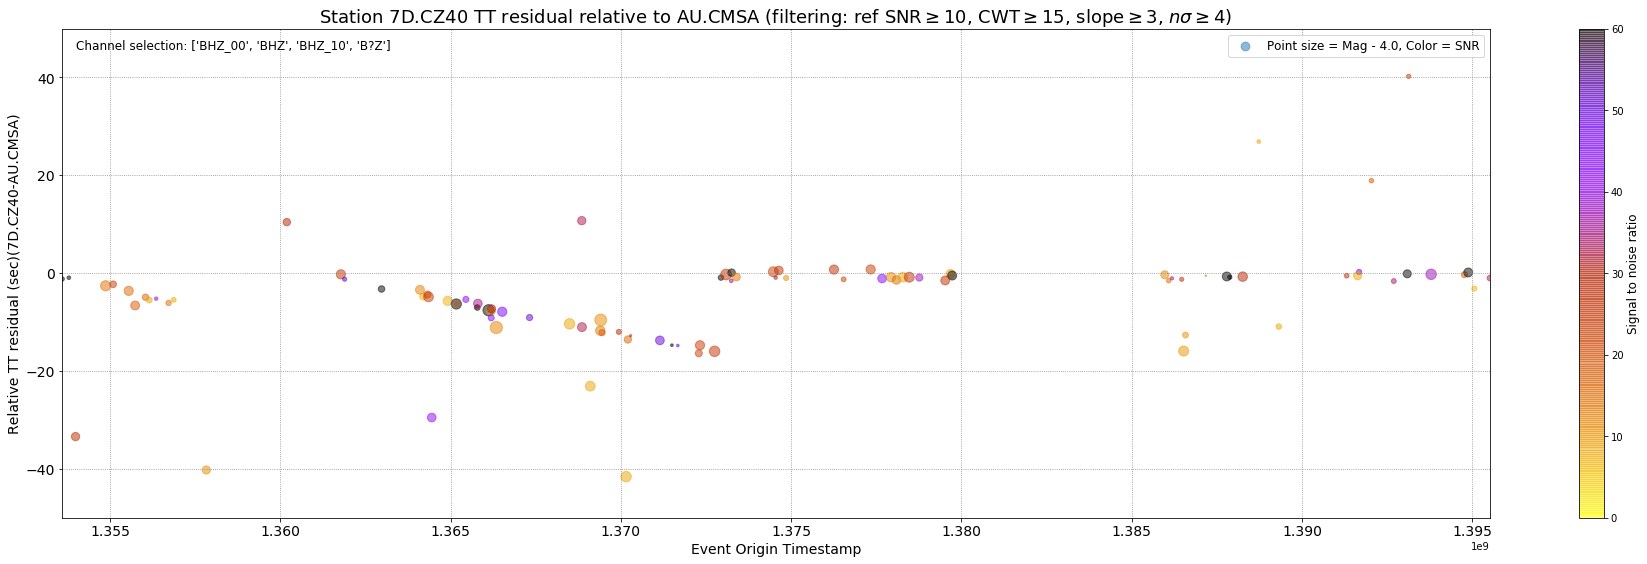

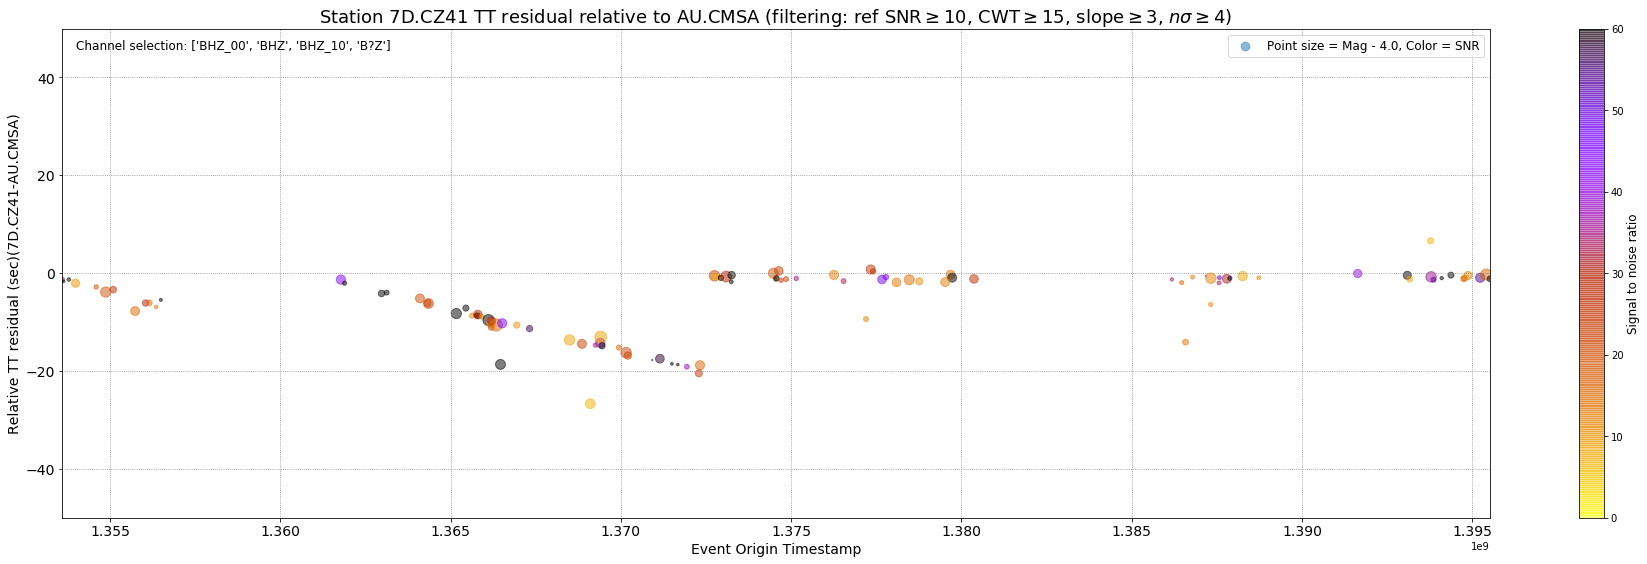

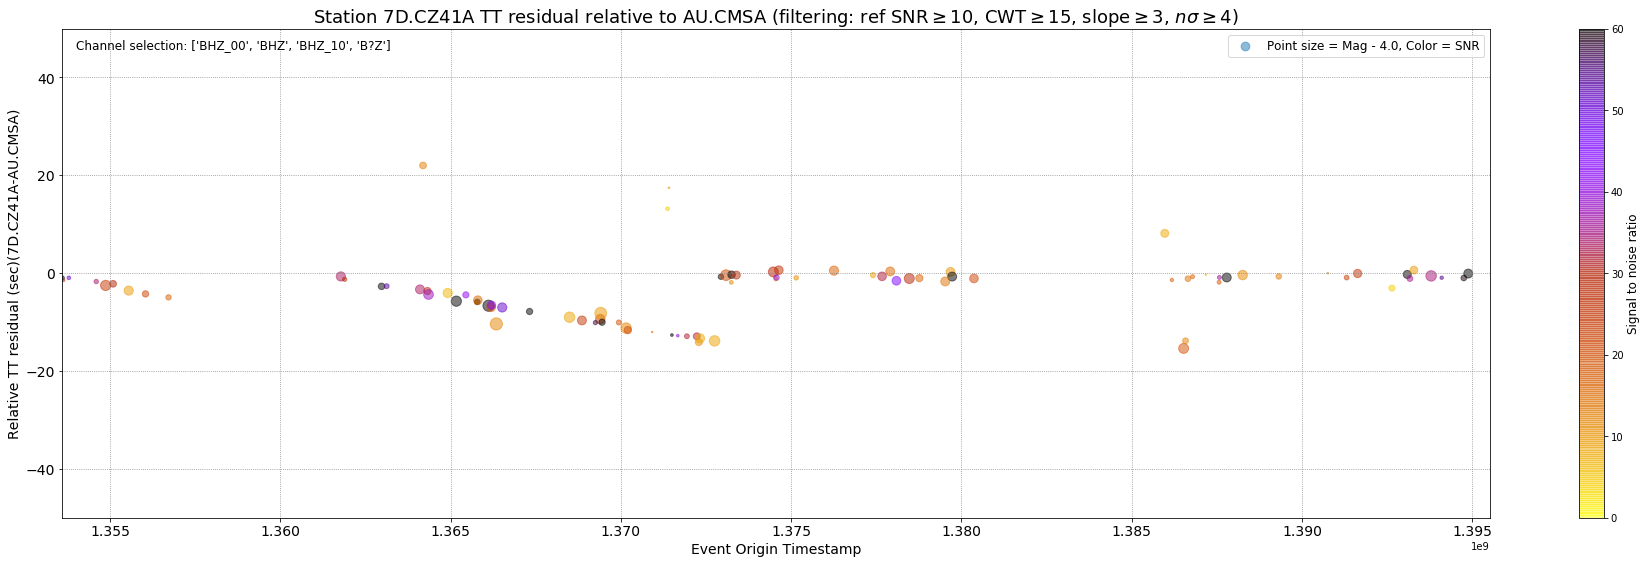

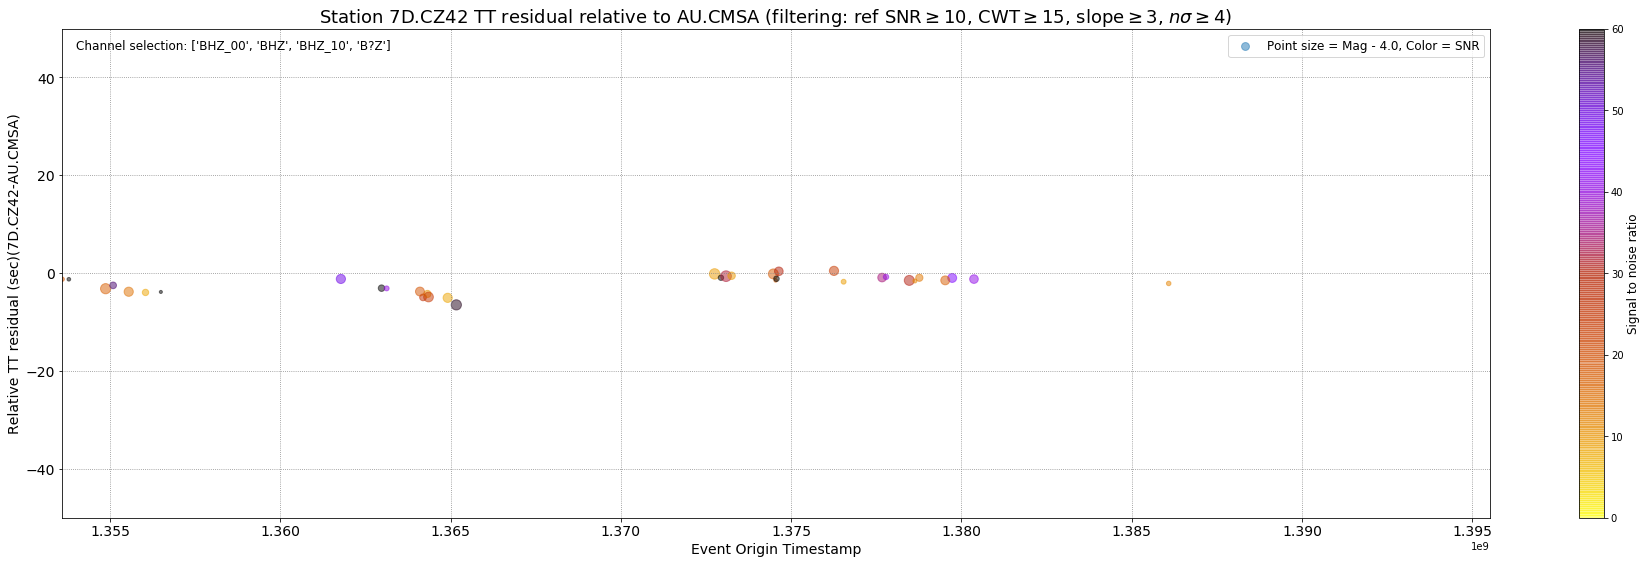

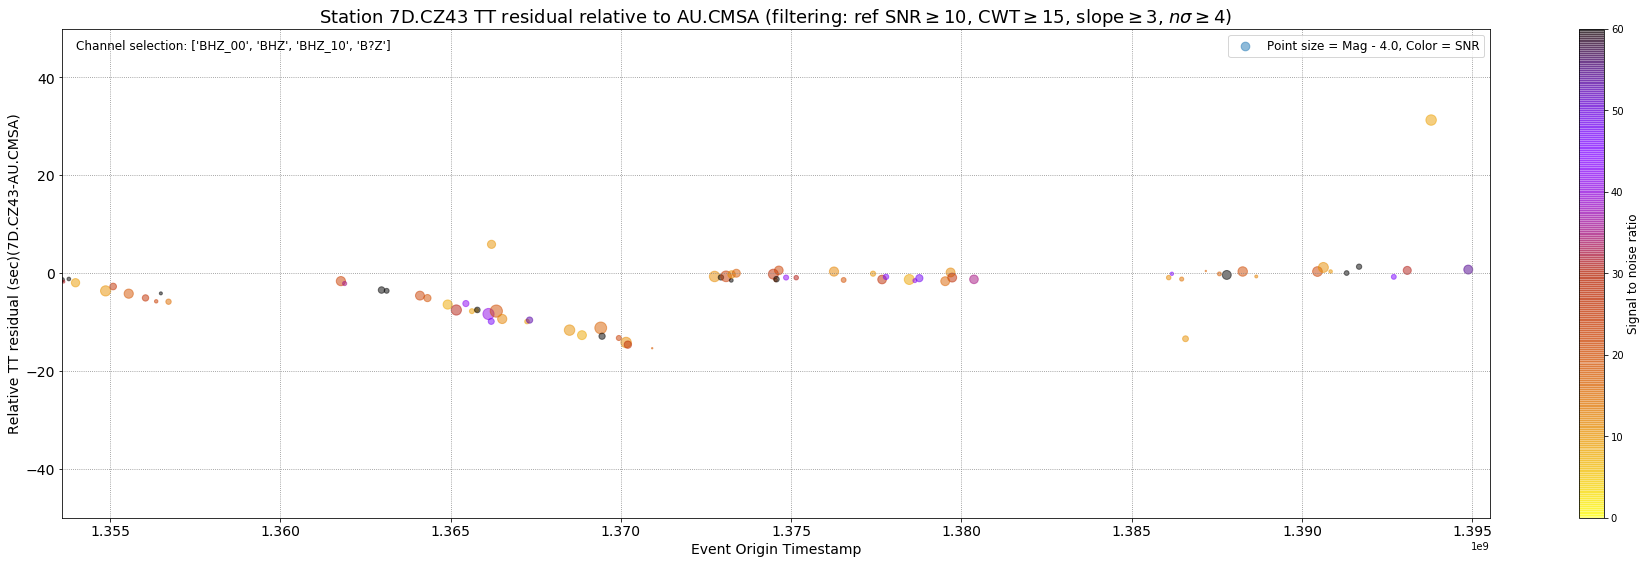

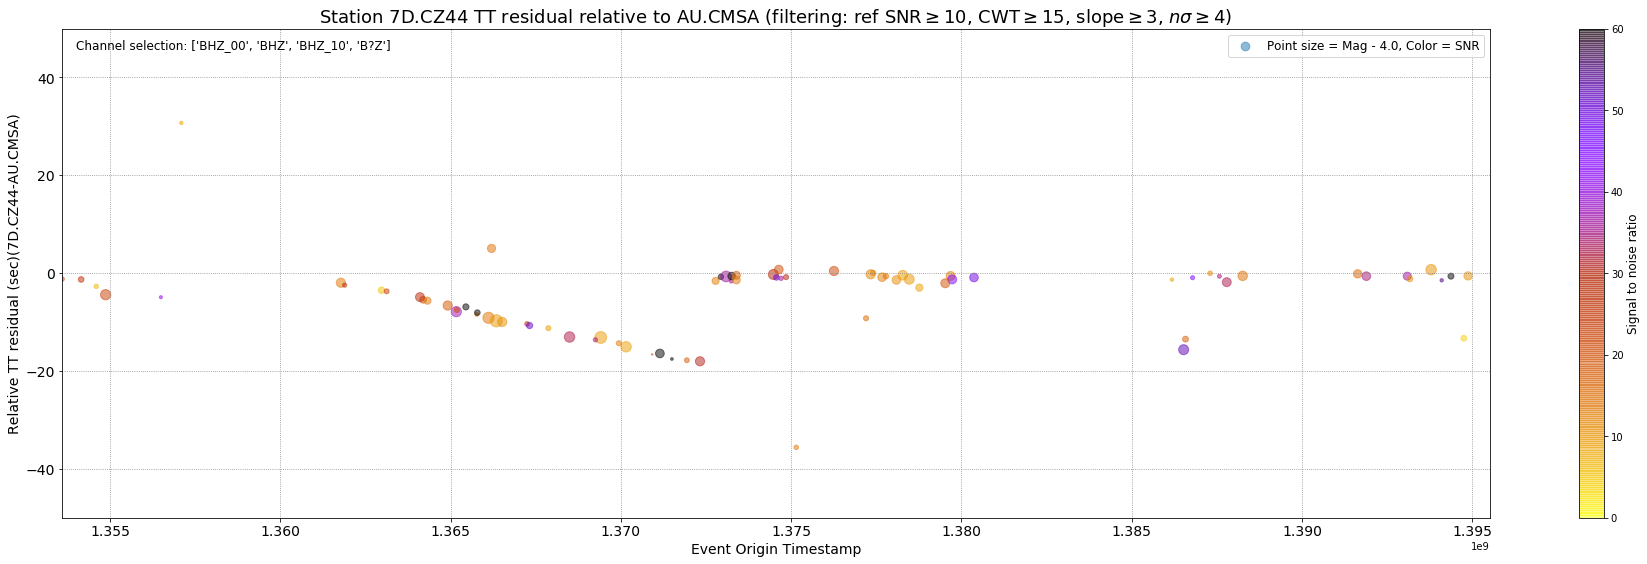

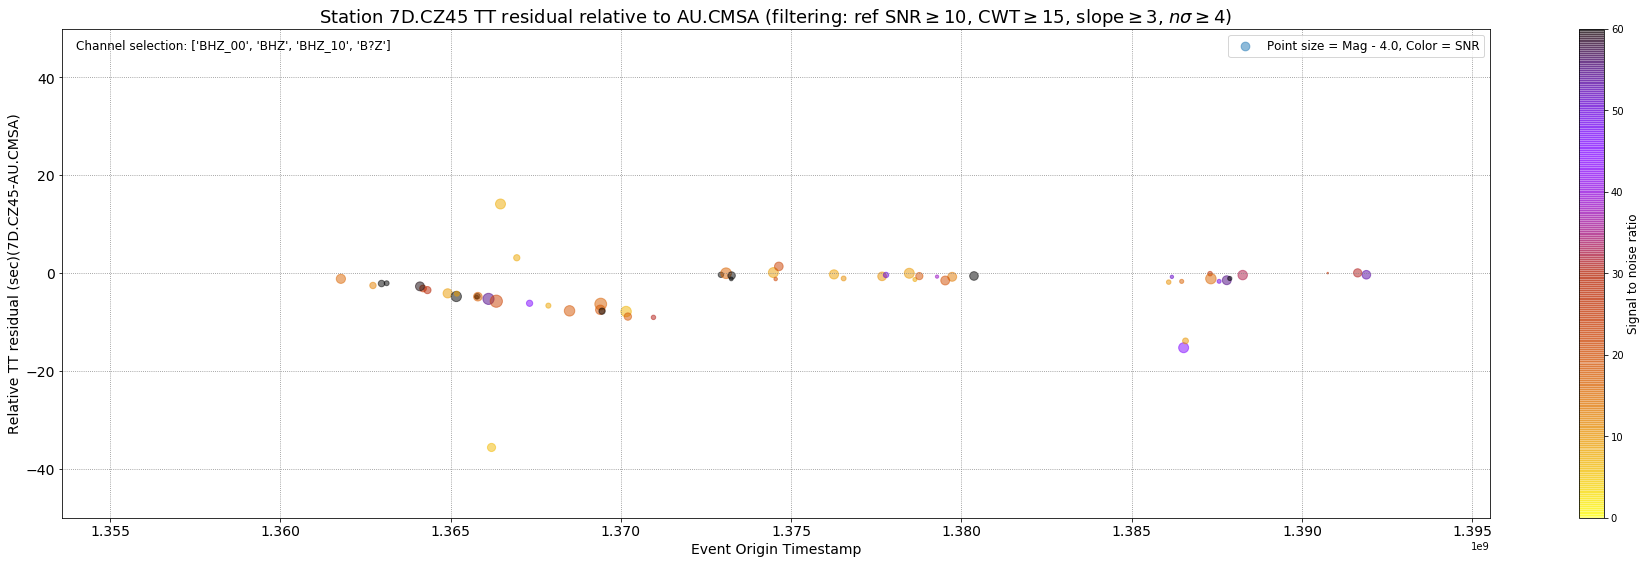

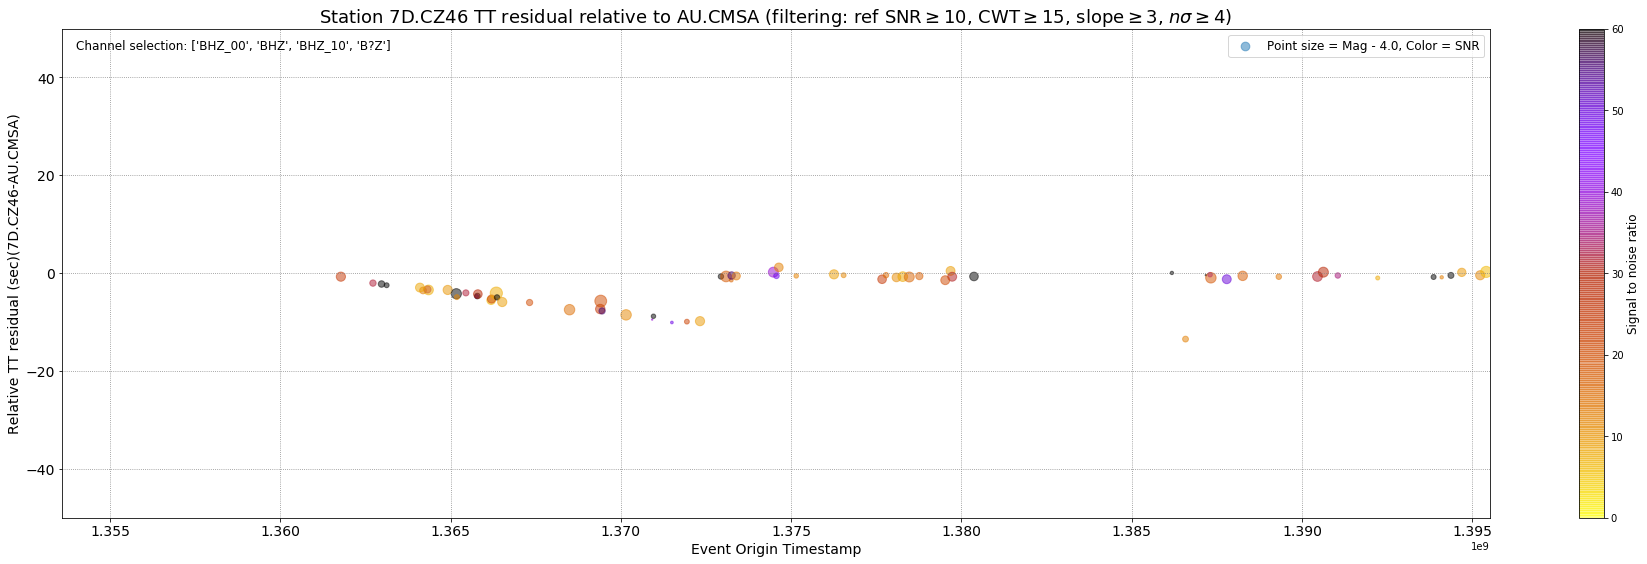

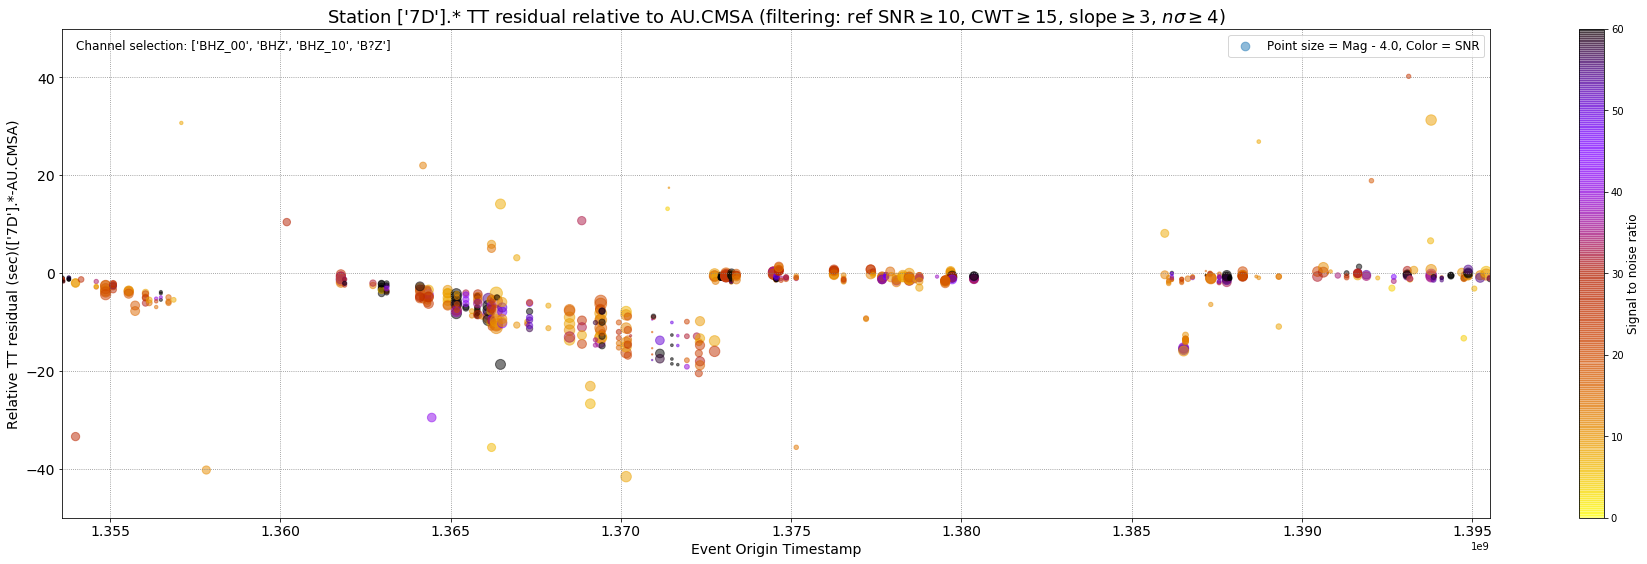

In [62]:
def add7DMarkerLines():
    for i, x in enumerate(np.array([1.354e9, 1.357e9, 1.362e9, 1.373e9])):
        plt.axvline(x, linestyle='--', linewidth=2, alpha=0.5, color='C'+str(i//2))
    plt.text(1.354e9, 40, 'Drift 1', horizontalalignment='right', fontsize=18, fontstyle='italic', alpha=0.6)
    plt.text(1.373e9, 40, 'Drift 2', horizontalalignment='left', fontsize=18, fontstyle='italic', alpha=0.6)
        
plotTargetNetworkRelResiduals(ds_final, TARGET_STNS, REF, save_file=True, plot_aggregate=True)
# plotTargetNetworkRelResiduals(ds_final, TARGET_STNS, REF, save_file=False, plot_aggregate=False, annotator=add7DMarkerLines)
# plotTargetNetworkRelResiduals(ds_final[(ds_final['originTimestamp'] >= 1.35e9) & (ds_final['originTimestamp'] <= 1.38e9)],
#                               TARGET_STNS, REF, save_file=False, plot_aggregate=False, annotator=add7DMarkerLines, file_label='(zoomed)')

In [ ]:
# Repeat, focusing on only results with high SNR
# df_high_snr = ds_final[ds_final['snr'] >= 10.0]
# plotTargetNetworkRelResiduals(df_high_snr, TARGET_STNS, REF, file_label='(high_SNR)', timeaxis=True)

In [ ]:
# Remove REF_STN from dataset used for this plot.
mask_targ_snr_plot = ds_final[list(TARGET_STNS)].isin(TARGET_STNS).all(axis=1)
ds_snr_plot = ds_final[mask_targ_snr_plot]

plt.figure(figsize=(32,9))

COLOR_BY_DATE=True
if COLOR_BY_DATE:
    # Color by date
    sc = plt.scatter(ds_snr_plot['relTtResidual'], ds_snr_plot['snr'], c=ds_snr_plot['pickTimestamp'].values, alpha=0.5, s=30*(ds_snr_plot['mag'] - 4))
    cb = plt.colorbar(sc)
    cb.set_label("Event Origin Timestamp")
    plt.legend(['Point size = Mag - 4.0, Color = Event Timestamp'], fontsize=12)
else:
    # Color by station code
    stations = sorted(list(set(ds_snr_plot['sta'].unique())))
    # print(stations)
    colors = ['C' + str(n%10) for n in range(len(stations))]
    # print(colors)
    cdict = dict(zip(stations, colors))
    cdict[REF_STN] = '#808080ff'
    plt.scatter(ds_snr_plot['relTtResidual'], ds_snr_plot['snr'], c=ds_snr_plot['sta'].apply(lambda x: cdict[x]).values, alpha=0.5, s=20*(ds_snr_plot['mag'] - 4))
    plt.legend(['Point size = Mag - 4.0, Color = station ID'], fontsize=12)

plt.grid(color='#80808080', linestyle=':')
plt.ylim((0,100))
plt.xlim((-55,55))
plt.xlabel("Relative TT residual (sec)")
plt.ylabel('SNR')
plt.title("SNR vs relative TT residual across target network {}".format(TARGET_NET))
plt.savefig('SNR_vs_relTtResidual.png', dpi=150)

In [ ]:
# # Find extreme event for KDU
# # mask = (ds_final['sta'] == 'KDU') & (ds_final['snr'] > 40) & (ds_final['relTtResidual'] < -25)
# mask = (ds_final['sta'] == 'KDU') & (ds_final['snr'] > 40) & (ds_final['relTtResidual'] < -25) & (ds_final['mag'] > 5.5)
# outlier = ds_final[mask]
# outlier

In [ ]:
# event_id = outlier['#eventID'].values[0]
# event_id

In [ ]:
# df_event = ds_final[ds_final['#eventID'] == event_id]
# display_styled_table(df_event)

In [ ]:
# pd.options.display.float_format = '{:.1f}'.format
# print(df_event[['#eventID', 'originTimestamp', 'mag', 'originLon', 'originLat', 'originDepthKm', 'net', 'sta', 'cha', 
#                 'pickTimestamp', 'phase', 'stationLon', 'stationLat', 'distance', 'ttResidual', 'relTtResidual', 'snr']])

In [ ]:
# obspy.UTCDateTime(1299832266.4)

In [ ]:
# getNetworkMean(df_picks, '7D')